<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
# Time series seasonal - exercises

--- 

In [1]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The following dataset contains seasonally non-adjusted quarterly data on income and consumption in the UK.

In [3]:
df = pd.read_csv('datasets/IncomeUK.csv')

In [4]:
df.head()

,income,consumption
0,9014,8016
1,9659,8798
2,9848,9184
3,10316,9755
4,10254,9113


### 0. The values represent quarterly data from 01/01/1971 to 30/06/1985.

Create the corresponding datetime index.

In [5]:
df['date']=pd.date_range('01/01/1971','30/06/1985',freq='Q')
df.set_index('date',drop=True,inplace=True)
df.head()

,income,consumption
date,,
1971-03-31,9014,8016
1971-06-30,9659,8798
1971-09-30,9848,9184
1971-12-31,10316,9755
1972-03-31,10254,9113


### 1. Plot the time series for consumption.

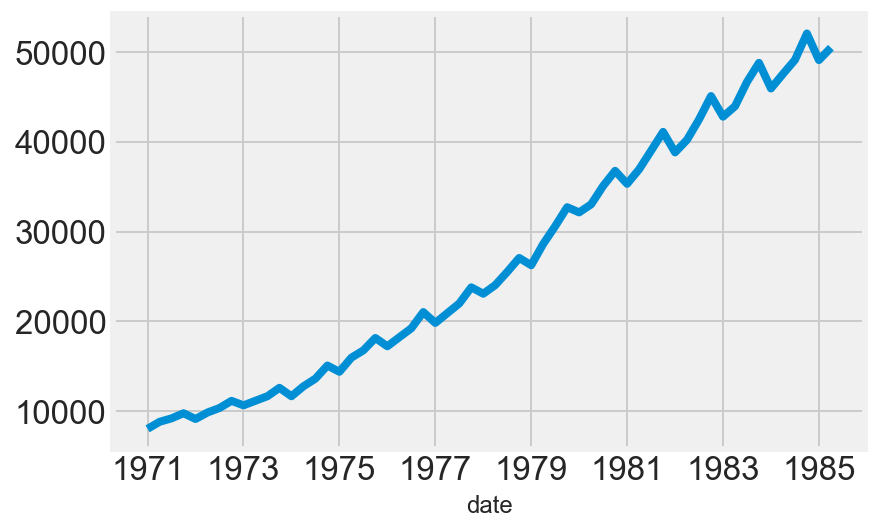

In [6]:
df.consumption.plot()

### 2. Which order of differencing would you recommend?

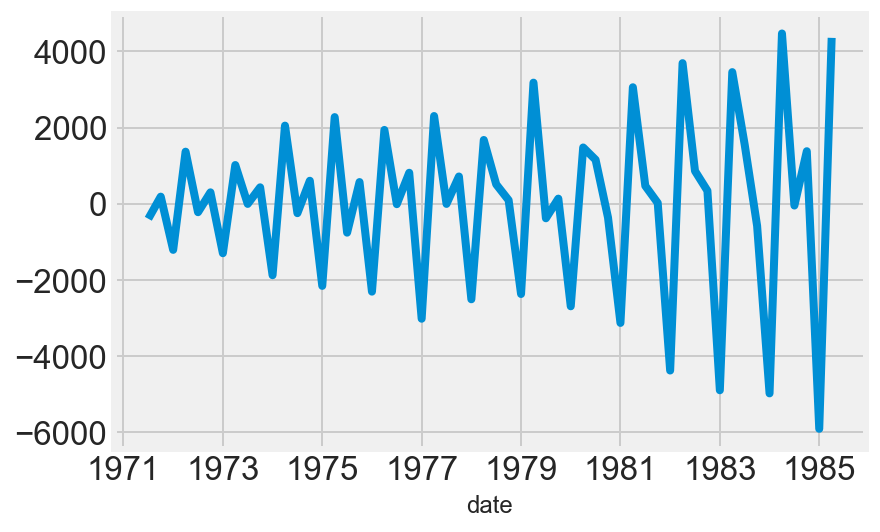

In [15]:
from statsmodels.tsa.stattools import adfuller
df.consumption.diff().diff().dropna().plot()
# second order differencing seems to be good here, but we can't say without using the Dickey-Fuller test.

### 3. Look at the autocorrelations and partial autocorrelations of consumption and its differences. Describe.

In [33]:
#it seems that we have good correlation between shifts.
from statsmodels.tsa.stattools import pacf,acf
acf(df.consumption,nlags=5)[1:],pacf(df.consumption,nlags=5)[1:]

(array([0.95230627, 0.9088966 , 0.85945789, 0.81698708, 0.76570074]),
 array([ 0.9690134 ,  0.03884775, -0.13226755,  0.0726143 , -0.17324868]))

### 4. Decompose into seasonal and non-seasonal parts.

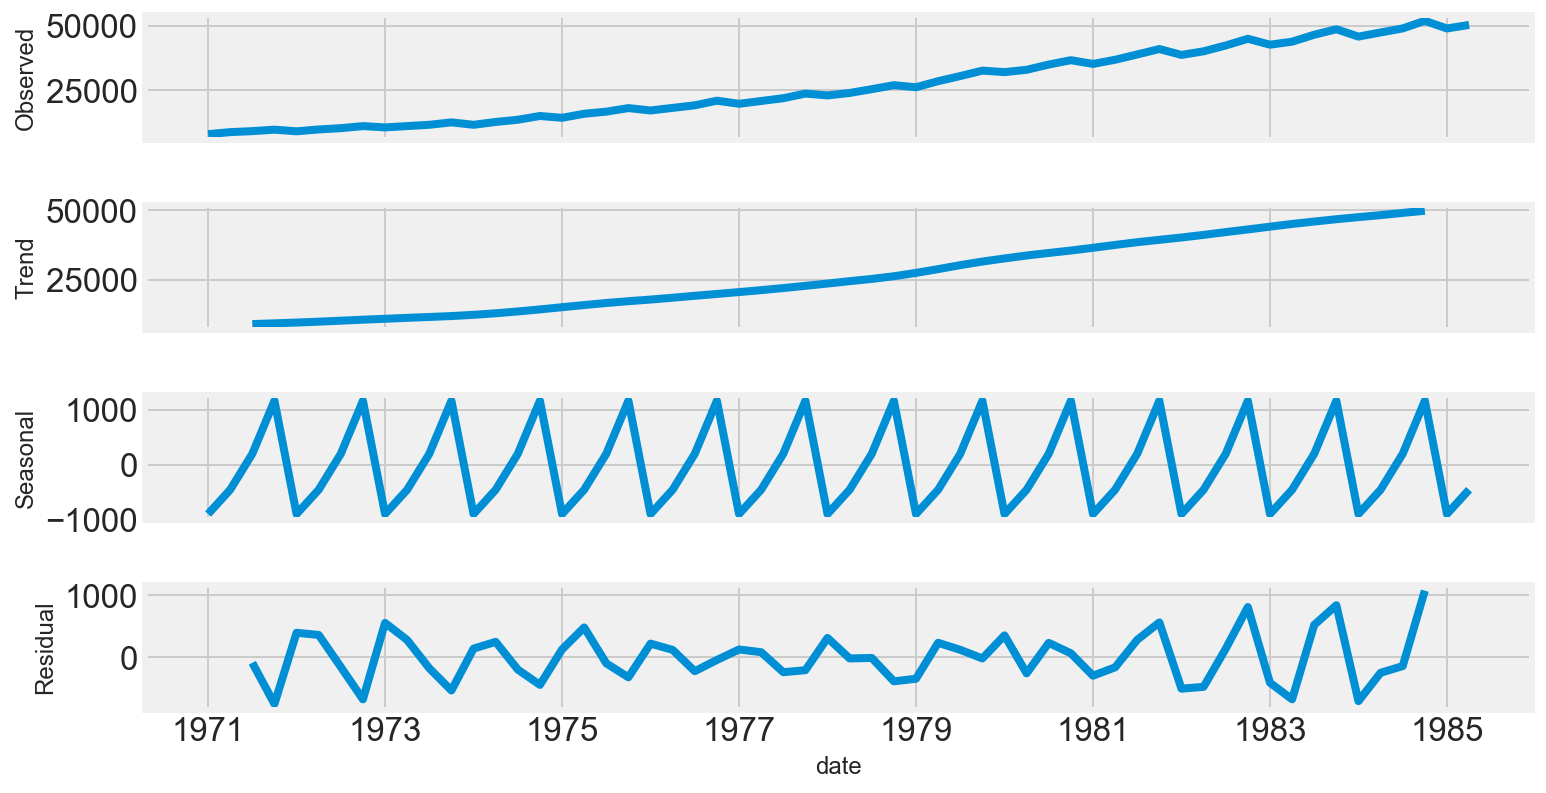

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
#plt.figure(figsize=(6,6))
seasonal_decompose(df.consumption).plot().set_size_inches(12,6)


### 5. Perform a Dickey-Fuller test for stationarity on consumption and its differences.

In [22]:
adfuller(df.consumption)


(-0.33469752222274335,
 0.9204443383986416,
 8,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 704.5867167020305)

In [23]:
adfuller(df.diff().dropna().consumption)

(-1.647875155314953,
 0.4581488286165527,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 686.7839161884011)

In [24]:
# the second difference seems to to be the good choice here
adfuller(df.diff().diff().dropna().consumption)

(-5.135772085940965,
 1.1873742734290505e-05,
 6,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 676.6448750691636)

### 6. Do you get better results in the Dickey-Fuller test if you take into account seasonality effects?

In [65]:
# yes much better
adfuller(((df.consumption-df.consumption.shift(8)).diff()).dropna())

(-6.736029662909845,
 3.2059403825885416e-09,
 0,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 578.886422146787)

### 7. Irrespective of your previous answers, fit a SARIMA model to consumption. Which parameters did you choose for the non-seasonal and seasonal components?

/Users/shadow/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


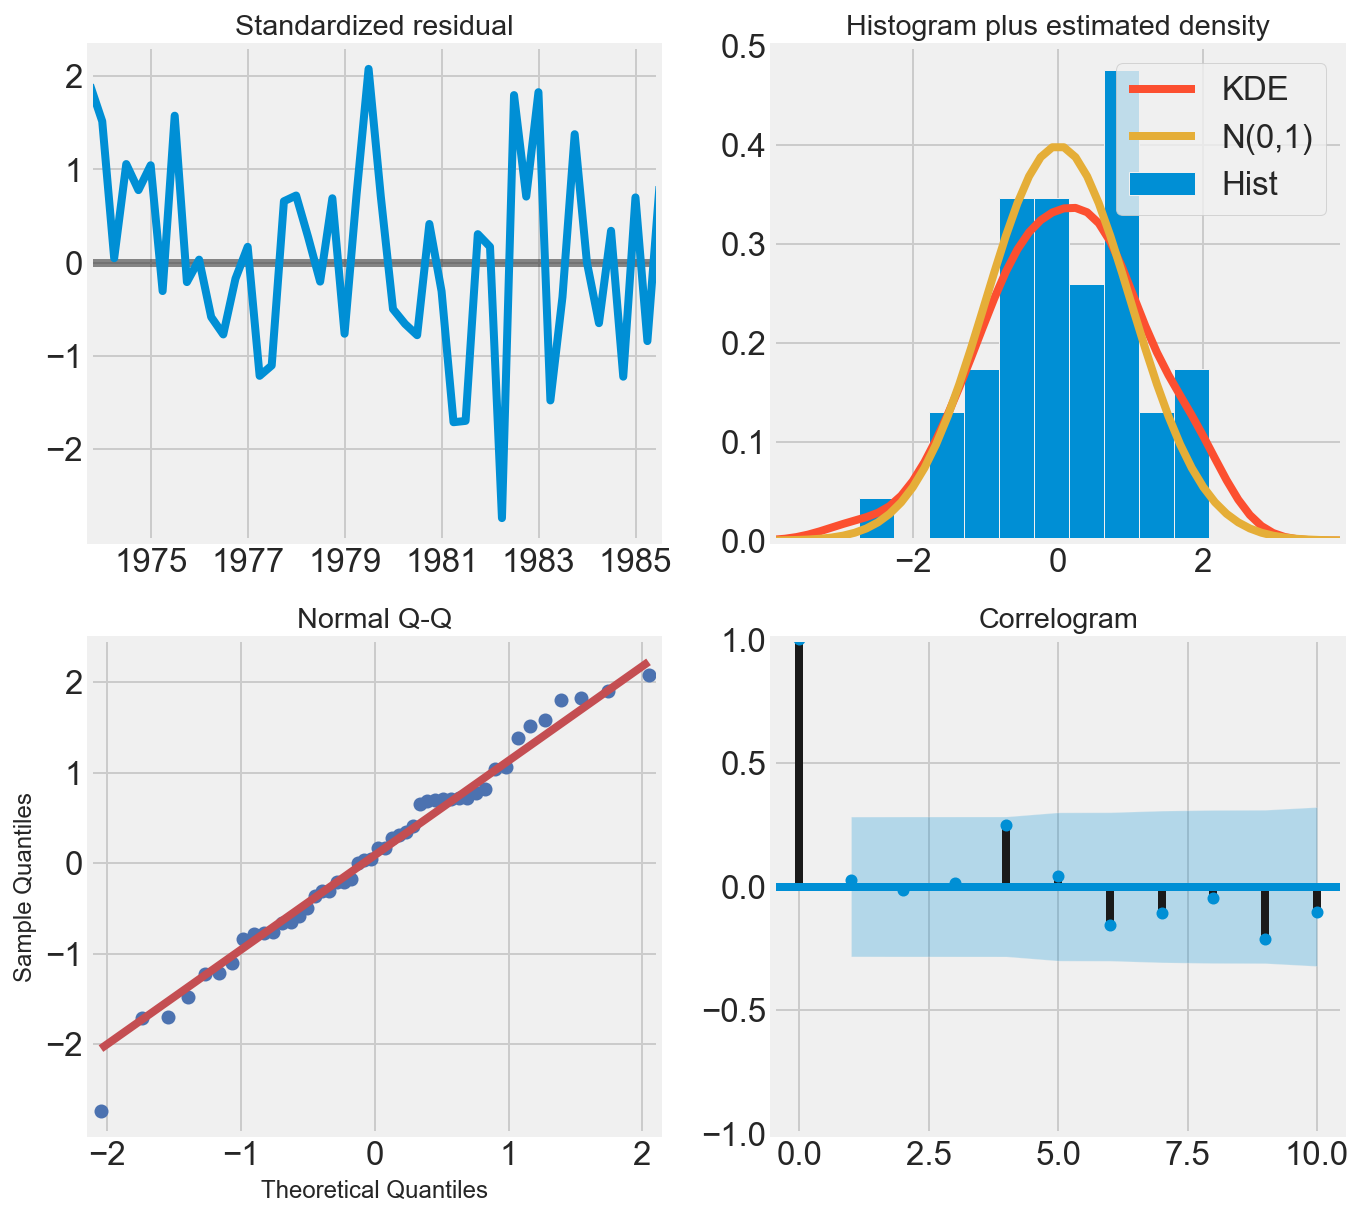

In [124]:
# we saw previously that scound order differance for ARIMA and first order difference of seasonal were needed for stationality.
sa=sm.tsa.statespace.SARIMAX(df.consumption,order=(0,2,1),seasonal_order=(0,1,1,8))
result=sa.fit()
result.plot_diagnostics(figsize=(10,10));

### 8. Describe your diagnostic plots of the residuals. Check for residual autocorrelations.

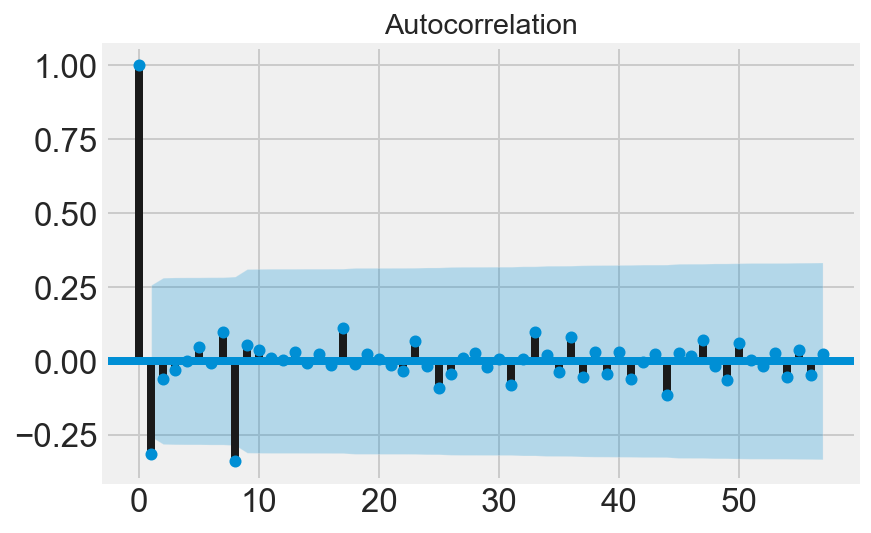

In [125]:
# we can see below that the residuals doesn't have much correlation with its lags.
plot_acf(result.resid);

### 9. Obtain fitted values with one-step ahead forecasts, in-sample forecasts and out-of sample forecasts. Compare the forecasts of different models.

In [140]:
result.predict(57,59,typ='levels')


1985-06-30    50005.164462
1985-09-30    53187.892953
1985-12-31    55232.206659
Freq: Q-DEC, dtype: float64

In [141]:
ARIMA(df.consumption,order=(0,2,1)).fit(typ=True).predict(57,59,typ='levels')

/Users/shadow/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
/Users/shadow/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


1985-06-30    50093.787033
1985-09-30    51489.093540
1985-12-31    52506.493518
Freq: Q-DEC, dtype: float64

In [142]:
ARMA(df.consumption,order=(0,1)).fit().predict(57,59)

/Users/shadow/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


1985-06-30    33589.917269
1985-09-30    41169.716887
1985-12-31    26839.760926
Freq: Q-DEC, dtype: float64

In [ ]:
# seasonal seems to move higher faster at least in the first new step, while ARMA seems to be awfull due to unstationarity.